# Random Forest


In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from __future__ import division
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
import sklearn as sk
import csv
import random

### Inputs

In [24]:
# specify the directory where all the data files are stored
the_dir = r'./ADNI'

# specify all the files to join
files_to_join = ['ADNIMERGE.csv','UPENNBIOMK_MASTER.csv']#'UCD_ADNI2_WMH_10_26_15.csv']

# specify fields that are not needed
fields_to_delete = ['PTID','SITE','EXAMDATE']

# specify the output file name
out_fn = ''

In [25]:
# read file
def read_file(fn):
    print ('Reading {}...'.format(fn))
    df = pd.read_csv(fn)
    # if VISCODE2 exists, use VISCODE2
    if 'VISCODE2' in df.columns:
        del df['VISCODE']
        df = df.rename(columns={"VISCODE2": "VISCODE"})
        #print (df[df[['RID','VISCODE']].duplicated()]) # to check duplicates
    return df

In [26]:
for fn in files_to_join:
    fn_dir = '{}/{}'.format(the_dir, fn)
    df = read_file(fn_dir)
    
    if fn == files_to_join[0]:
        df_all = df.copy()
    else:
        df_all = pd.merge(df_all, df, how='inner', on=['RID', 'VISCODE'])
    print ('{} columns included.'.format(len(df_all.columns)))
    print ('{} samples remaining.'.format(len(df_all.index)))

df_all.head()

Reading ./ADNI/ADNIMERGE.csv...
94 columns included.
13017 samples remaining.
Reading ./ADNI/UPENNBIOMK_MASTER.csv...
106 columns included.
5869 samples remaining.


,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,STDS,DRWDTE,RUNDATE,ABETA,TAU,PTAU,ABETA_RAW,TAU_RAW,PTAU_RAW,update_stamp_y
0,3,011_S_0003,bl,11,ADNI1,ADNI1,9/12/05,AD,81.3,Male,...,167082,2005-09-12,2007-10-26,131.0,68.0,21.0,131.0,68.0,21.0,2016-07-06 16:15:51.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,9/12/05,AD,81.3,Male,...,181286,2005-09-12,2008-11-12,132.0,54.9,19.8,149.0,55.5,12.8,2016-07-06 16:15:51.0
2,3,011_S_0003,bl,11,ADNI1,ADNI1,9/12/05,AD,81.3,Male,...,ALL,2005-09-12,2016-03-09,131.0,61.4,20.4,NaN,NaN,NaN,2016-07-06 16:15:51.0
3,3,011_S_0003,m12,11,ADNI1,ADNI1,9/12/06,AD,81.3,Male,...,181286,2006-09-13,2008-11-12,137.0,76.5,21.1,155.0,77.5,13.7,2016-07-06 16:15:51.0
4,3,011_S_0003,m12,11,ADNI1,ADNI1,9/12/06,AD,81.3,Male,...,ALL,2006-09-13,2016-03-09,137.0,76.5,21.1,NaN,NaN,NaN,2016-07-06 16:15:51.0


In [27]:
print (df_all.columns[:20])
print (df_all.columns[21:])

Index(['RID', 'PTID', 'VISCODE', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE',
       'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45', 'CDRSB', 'ADAS11'],
      dtype='object')
Index(['MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION',
       'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform',
       'MidTemp', 'ICV', 'DX', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl',
       'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl',
       'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'FAQ_bl',
       'FLDSTRENG_bl', 'FSVERSION_bl', 'Ventricles_bl', 'Hippocampus_bl',
       'WholeBrain_bl', '

### Feature Engineering

In [28]:
# delete fields you dont need

fields_to_delete = ['DX_bl','PTID','SITE','COLPROT','ORIGPROT','EXAMDATE','EXAMDATE_bl',
                    'BATCH','DRWDTE','RUNDATE','update_stamp_y','KIT','STDS','update_stamp_x',
                    'FLDSTRENG_bl','FSVERSION_bl','CDRSB','CDRSB_bl','MMSE','MMSE_bl','FAQ',
                    'FAQ_bl','RAVLT_immediate','RAVLT_immediate_bl','RAVLT_learning',
                    'RAVLT_learning_bl','RAVLT_perc_forgetting_bl','RAVLT_perc_forgetting',
                    'RAVLT_forgetting', 'RAVLT_forgetting_bl']

for field in fields_to_delete:
    del df_all[field]

print ('{} columns included.'.format(len(df_all.columns)))

76 columns included.


In [29]:
# add pct change variables
remeasure_cols = ['Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']
for col in remeasure_cols:
    df_all[str(col+'_pct_delta')] = (df_all[col] - df_all[str(col+'_bl')])/df_all[str(col+'_bl')]

In [30]:
# check string fields
df_ob_cols = df_all.select_dtypes(include=[object])
for col in df_ob_cols.columns:
    print (col,df_ob_cols[col].unique())

VISCODE ['bl' 'm12' 'm24' 'm48' 'm60' 'm36' 'm72' 'm84']
PTGENDER ['Male' 'Female']
PTETHCAT ['Not Hisp/Latino' 'Hisp/Latino' 'Unknown']
PTRACCAT ['White' 'Black' 'Asian' 'More than one' 'Am Indian/Alaskan' 'Unknown'
 'Hawaiian/Other PI']
PTMARRY ['Married' 'Widowed' 'Divorced' 'Never married' 'Unknown']
FLDSTRENG ['1.5 Tesla MRI' '3 Tesla MRI' nan]
FSVERSION ['Cross-Sectional FreeSurfer (FreeSurfer Version 4.3)'
 'Cross-Sectional FreeSurfer (5.1)' nan]
DX ['Dementia' 'MCI' 'CN']


In [31]:
# perform onehot encoding for the categoricals
fields_one_hot = ['PTGENDER','PTETHCAT','PTRACCAT','PTMARRY','FLDSTRENG','FSVERSION']
df_all_with_dummy = pd.get_dummies(df_all, columns=fields_one_hot, dummy_na=True, drop_first=True)
df_all_with_dummy.head()

,RID,VISCODE,AGE,PTEDUCAT,APOE4,FDG,PIB,AV45,ADAS11,ADAS13,...,PTRACCAT_nan,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed,PTMARRY_nan,FLDSTRENG_3 Tesla MRI,FLDSTRENG_nan,FSVERSION_Cross-Sectional FreeSurfer (FreeSurfer Version 4.3),FSVERSION_nan
0,3,bl,81.3,18,1.0,1.09079,NaN,NaN,22.0,31.0,...,0,1,0,0,0,0,0,0,1,0
1,3,bl,81.3,18,1.0,1.09079,NaN,NaN,22.0,31.0,...,0,1,0,0,0,0,0,0,1,0
2,3,bl,81.3,18,1.0,1.09079,NaN,NaN,22.0,31.0,...,0,1,0,0,0,0,0,0,1,0
3,3,m12,81.3,18,1.0,1.10384,NaN,NaN,24.0,35.0,...,0,1,0,0,0,0,0,0,1,0
4,3,m12,81.3,18,1.0,1.10384,NaN,NaN,24.0,35.0,...,0,1,0,0,0,0,0,0,1,0


In [32]:
df_all.isnull().sum()

RID                         0
VISCODE                     0
AGE                         0
PTGENDER                    0
PTEDUCAT                    0
PTETHCAT                    0
PTRACCAT                    0
PTMARRY                     0
APOE4                       0
FDG                      1817
PIB                      5615
AV45                     3224
ADAS11                     16
ADAS13                     59
MOCA                     3176
EcogPtMem                3165
EcogPtLang               3169
EcogPtVisspat            3185
EcogPtPlan               3169
EcogPtOrgan              3236
EcogPtDivatt             3185
EcogPtTotal              3167
EcogSPMem                3167
EcogSPLang               3167
EcogSPVisspat            3211
EcogSPPlan               3195
EcogSPOrgan              3279
EcogSPDivatt             3234
EcogSPTotal              3171
FLDSTRENG                 745
                         ... 
EcogPtOrgan_bl           3397
EcogPtDivatt_bl          3356
EcogPtTota

In [33]:
# delete col with too little 1s
fields_to_delete = ['PTRACCAT_Unknown']
for col in fields_to_delete:
    del df_all_with_dummy[col]

5869
54


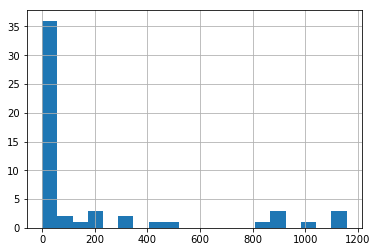

In [34]:
%matplotlib inline
# deal with missing data
# sum up the missings
print (len(df_all_with_dummy.index))
a = df_all_with_dummy.isnull().sum()
#print (len(a[a<1200]))
# exclude all features with more than 1200 nulls
df_all_with_dummy = df_all_with_dummy[a[a<1200].index]
print (len(df_all_with_dummy.columns))
a = df_all_with_dummy.isnull().sum()
a.hist(bins=20)

In [35]:
df_all_with_dummy.columns

Index(['RID', 'VISCODE', 'AGE', 'PTEDUCAT', 'APOE4', 'ADAS11', 'ADAS13',
       'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform',
       'MidTemp', 'ICV', 'DX', 'ADAS11_bl', 'ADAS13_bl', 'Ventricles_bl',
       'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl',
       'MidTemp_bl', 'ICV_bl', 'Years_bl', 'Month_bl', 'Month', 'M', 'ABETA',
       'TAU', 'PTAU', 'Ventricles_pct_delta', 'WholeBrain_pct_delta',
       'ICV_pct_delta', 'PTGENDER_Male', 'PTGENDER_nan',
       'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown', 'PTETHCAT_nan',
       'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
       'PTRACCAT_More than one', 'PTRACCAT_White', 'PTRACCAT_nan',
       'PTMARRY_Married', 'PTMARRY_Never married', 'PTMARRY_Unknown',
       'PTMARRY_Widowed', 'PTMARRY_nan', 'FLDSTRENG_3 Tesla MRI',
       'FLDSTRENG_nan',
       'FSVERSION_Cross-Sectional FreeSurfer (FreeSurfer Version 4.3)',
       'FSVERSION_nan'],
      dtype='object')

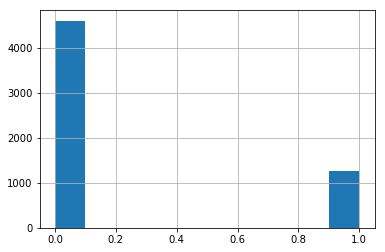

In [36]:
# generate y col based on DX
df_all_with_dummy['y'] = 0
df_all_with_dummy.loc[df_all_with_dummy['DX']=='Dementia','y']=1
df_all_with_dummy.y.hist()


In [37]:
import numpy as np

In [39]:
# split train test data based on RID
print (len(df_all_with_dummy['RID'].unique()))
df_grp = df_all_with_dummy.groupby('RID')


df_train = []
df_test = []
for idx, grp in df_grp:
    if np.random.choice([0,1], p=[0.2, 0.8]) == 1:
        try:
            #print (grp)
            df_train = df_train.append(grp)
        except:
            df_train = grp.copy()
    else:
        try: 
            df_test = df_test.append(grp)
        except:
            df_test = grp.copy()

print (len(df_train.index))
print (len(df_test.index))
#df_all_with_dummy_standardized = df_all_with_dummy - df_all_with_dummy.mean()

#df_all_with_dummy

1249
4577
1282


In [40]:
# standardize training data
y_train = df_train.y
y_test = df_test.y

del df_train['y']
del df_train['DX']
del df_test['y']
del df_test['DX']

In [41]:
df_train.head()

,RID,VISCODE,AGE,PTEDUCAT,APOE4,ADAS11,ADAS13,Ventricles,Hippocampus,WholeBrain,...,PTRACCAT_nan,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed,PTMARRY_nan,FLDSTRENG_3 Tesla MRI,FLDSTRENG_nan,FSVERSION_Cross-Sectional FreeSurfer (FreeSurfer Version 4.3),FSVERSION_nan
5,4,bl,67.5,10,0.0,14.33,21.33,39605.0,6869.0,1154980.0,...,0,1,0,0,0,0,0,0,1,0
6,4,bl,67.5,10,0.0,14.33,21.33,39605.0,6869.0,1154980.0,...,0,1,0,0,0,0,0,0,1,0
7,4,bl,67.5,10,0.0,14.33,21.33,39605.0,6869.0,1154980.0,...,0,1,0,0,0,0,0,0,1,0
8,4,m12,67.5,10,0.0,15.00,22.00,38527.0,6451.0,1117390.0,...,0,1,0,0,0,0,0,0,1,0
9,4,m12,67.5,10,0.0,15.00,22.00,38527.0,6451.0,1117390.0,...,0,1,0,0,0,0,0,0,1,0


In [42]:
X_train = df_train.iloc[:,2:]
X_test = df_test.iloc[:,2:]
X_train.head()

,AGE,PTEDUCAT,APOE4,ADAS11,ADAS13,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,...,PTRACCAT_nan,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed,PTMARRY_nan,FLDSTRENG_3 Tesla MRI,FLDSTRENG_nan,FSVERSION_Cross-Sectional FreeSurfer (FreeSurfer Version 4.3),FSVERSION_nan
5,67.5,10,0.0,14.33,21.33,39605.0,6869.0,1154980.0,3983.0,19036.0,...,0,1,0,0,0,0,0,0,1,0
6,67.5,10,0.0,14.33,21.33,39605.0,6869.0,1154980.0,3983.0,19036.0,...,0,1,0,0,0,0,0,0,1,0
7,67.5,10,0.0,14.33,21.33,39605.0,6869.0,1154980.0,3983.0,19036.0,...,0,1,0,0,0,0,0,0,1,0
8,67.5,10,0.0,15.00,22.00,38527.0,6451.0,1117390.0,3519.0,18691.0,...,0,1,0,0,0,0,0,0,1,0
9,67.5,10,0.0,15.00,22.00,38527.0,6451.0,1117390.0,3519.0,18691.0,...,0,1,0,0,0,0,0,0,1,0


In [43]:
# standardize train data
X_train_stand = (X_train - X_train.mean())/(X_train.max() - X_train.min())
# testing data
X_test_stand = (X_test - X_train.mean())/(X_train.max() - X_train.min())

In [44]:
# replace all nan with mean (0)
X_train_stand.fillna(0,inplace=True)
X_test_stand.fillna(0,inplace=True)

In [45]:
# save the data 
print (X_train_stand.shape)
print (X_test_stand.shape)
print (y_train.shape)
print (y_test.shape)

X_train_stand.to_csv('./data/X_train_null_1200.csv',index=False)
X_test_stand.to_csv('./data/X_test_null_1200.csv',index=False)
y_train.to_csv('./data/y_train_null_1200.csv',index=False)
y_test.to_csv('./data/y_test_null_1200.csv',index=False)

(4577, 51)
(1282, 51)
(4577,)
(1282,)


### Model Building

#### RF

In [46]:
from itertools import product
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [47]:
### baseline RF model
rf = RandomForestClassifier(random_state = 100)
rf.fit(X_train_stand, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=100,
            verbose=0, warm_start=False)

In [48]:
print(rf.score(X_test_stand, y_test))

0.86895475819


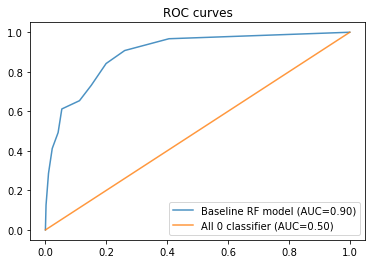

In [150]:
### ROC for baseline model
fpr1, tpr1, thres1 = roc_curve(y_test, rf.predict_proba(X_test_stand)[:,1])
fpr2, tpr2, thres2 = roc_curve(y_test, np.zeros((len(y_test), 1)))
auc1 = roc_auc_score(y_test, rf.predict_proba(X_test_stand)[:,1])
auc2 = roc_auc_score(y_test, np.zeros((len(y_test), 1)))

fig, ax = plt.subplots(1,1)
ax.plot(fpr1, tpr1, '-', alpha=0.8, label='Baseline RF model (AUC=%.2f)' % (auc1))
ax.plot(fpr2, tpr2, '-', alpha=0.8, label='All 0 classifier (AUC=%.2f)' % (auc2))
plt.title("ROC curves")
plt.legend()

In [154]:
print('Baseline RF model gives AUC of {:.3f}'.format(roc_auc_score(y_test, rf.predict_proba(X_test_stand)[:,1])))

Baseline RF model gives AUC of 0.898


In [155]:
### param tuning
depth = [1,2,5,10,20,50,100,None]
ns = [10, 20, 50, 100, 150, 200]

accs = pd.DataFrame(np.zeros((len(depth)*len(ns), 3)))
accs.columns = ['max_depth','n_est','AUC']

i = 0
kf = KFold(n_splits=5)
for d in depth:
    for n in ns:
        print("depth:{}, n:{}".format(d,n))
        acc_cv = []
        
        for train, val in kf.split(X_train_stand):
            train_X, train_y, val_X, val_y = X_train_stand.iloc[train,:], pd.DataFrame(y_train).iloc[train,:], X_train_stand.iloc[val,:], pd.DataFrame(y_train).iloc[val,:]
            rf_temp = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=100)
            rf_temp.fit(train_X, train_y.values.ravel())
            acc_cv.append(roc_auc_score(val_y, rf_temp.predict_proba(val_X)[:,1]))

        accs.iloc[i,:] = [d, n, np.mean(acc_cv)]
        i+=1

depth:1, n:10
depth:1, n:20
depth:1, n:50
depth:1, n:100
depth:1, n:150
depth:1, n:200
depth:2, n:10
depth:2, n:20
depth:2, n:50
depth:2, n:100
depth:2, n:150
depth:2, n:200
depth:5, n:10
depth:5, n:20
depth:5, n:50
depth:5, n:100
depth:5, n:150
depth:5, n:200
depth:10, n:10
depth:10, n:20
depth:10, n:50
depth:10, n:100
depth:10, n:150
depth:10, n:200
depth:20, n:10
depth:20, n:20
depth:20, n:50
depth:20, n:100
depth:20, n:150
depth:20, n:200
depth:50, n:10
depth:50, n:20
depth:50, n:50
depth:50, n:100
depth:50, n:150
depth:50, n:200
depth:100, n:10
depth:100, n:20
depth:100, n:50
depth:100, n:100
depth:100, n:150
depth:100, n:200
depth:None, n:10
depth:None, n:20
depth:None, n:50
depth:None, n:100
depth:None, n:150
depth:None, n:200


In [156]:
accs.sort_values(by = 'AUC', ascending=False).head()

,max_depth,n_est,AUC
17,5.0,200.0,0.931572
15,5.0,100.0,0.930886
16,5.0,150.0,0.930589
14,5.0,50.0,0.929270
13,5.0,20.0,0.928254


In [67]:
### best model
rf_best1 = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=100)
rf_best1.fit(X_train_stand, y_train)
rf_best1.score(X_test_stand, y_test)

0.89079563182527299

In [68]:
### ROC for best model
fpr1, tpr1, thres1 = roc_curve(y_test, rf_best1.predict_proba(X_test_stand)[:,1])
fpr2, tpr2, thres2 = roc_curve(y_test, np.zeros((len(y_test), 1)))
auc1 = roc_auc_score(y_test, rf_best1.predict_proba(X_test_stand)[:,1])
auc2 = roc_auc_score(y_test, np.zeros((len(y_test), 1)))

In [159]:
print('Best RF model gives AUC of {:.3f}'.format(roc_auc_score(y_test, rf_best1.predict_proba(X_test_stand)[:,1])))

Best RF model gives AUC of 0.907


### Xgboosting

In [2]:
# read data
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load the data
X_train = pd.read_csv('X_train_null_1200.csv').as_matrix()
X_test = pd.read_csv('X_test_null_1200.csv').as_matrix()
y_train = pd.read_csv('y_train_null_1200.csv', header=None).as_matrix()
y_test = pd.read_csv('y_test_null_1200.csv', header=None).as_matrix()
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

(5241, 50)
(5241, 1)
(628, 50)
(628, 1)


In [14]:
# We'll impute missing values using the median for numeric columns and the most
# common value for string columns.
# This is based on some nice code by 'sveitser' at http://stackoverflow.com/a/25562948
# from sklearn.base import TransformerMixin
# class DataFrameImputer(TransformerMixin):
#     def fit(self, X, y=None):
#         self.fill = pd.Series([X[c].value_counts().index[0]
#             if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
#             index=X.columns)
#         return self
#     def transform(self, X, y=None):
#         return X.fillna(self.fill)

# feature_columns_to_use = ['Pclass','Sex','Age','Fare','Parch']
# nonnumeric_columns = ['Sex']

# Join the features from train and test together before imputing missing values,
# in case their distribution is slightly different
# big_X = train_df[feature_columns_to_use].append(test_df[feature_columns_to_use])
# big_X_imputed = DataFrameImputer().fit_transform(big_X)

# XGBoost doesn't (yet) handle categorical features automatically, so we need to change
# them to columns of integer values.
# See http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing for more
# details and options
# le = LabelEncoder()
# for feature in nonnumeric_columns:
#     big_X_imputed[feature] = le.fit_transform(big_X_imputed[feature])


#xgboost_params
param = {}
param['booster']='gbtree'
param['objective'] = 'binary:logistic'
param['bst:eta'] = 0.04
param['seed']=  0
param['bst:max_depth'] = 7
param['silent'] =  1  
param['nthread'] = 12 # put more if you have
param['bst:subsample'] = 0.7
param['gamma'] = 1.0
param['colsample_bytree']= 1.0
param['num_parallel_tree']= 10
param['colsample_bylevel']= 0.7                  
param['lambda']=1
param['eval_metric'] = 'error'

evallist = [(dtest,'eval'),(dtrain,'train')]
watchlist = [(dtest,'eval')]

# You can experiment with many other options here, using the same .fit() and .predict()
# methods; see http://scikit-learn.org
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost

# Kaggle needs the submission to have a certain format;
# see https://www.kaggle.com/c/titanic-gettingStarted/download/gendermodel.csv
# for an example of what it's supposed to look like.


In [15]:
num_round = 500
xgb.cv(param, dtrain, num_round, nfold=5,
       metrics={'error'}, seed=0, early_stopping_rounds = 50,
       callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
#bst.save_model('0001.model')
#bst.dump_model('dump0001.raw.txt')

[0]	train-error:0.0543788+0.00564696	test-error:0.0774642+0.00977699
[1]	train-error:0.0476534+0.00196409	test-error:0.0747924+0.0112659
[2]	train-error:0.0431216+0.00269346	test-error:0.0675422+0.0110527
[3]	train-error:0.0394486+0.00123362	test-error:0.0662064+0.0104792
[4]	train-error:0.0354894+0.00101709	test-error:0.0658244+0.0106206
[5]	train-error:0.0321504+0.0019513	test-error:0.060672+0.0104223
[6]	train-error:0.0288114+0.00159212	test-error:0.0580018+0.00917999
[7]	train-error:0.0265216+0.00210934	test-error:0.0549488+0.00990925
[8]	train-error:0.024089+0.00109996	test-error:0.0530412+0.0100403
[9]	train-error:0.0214652+0.000867452	test-error:0.0503696+0.00968534
[10]	train-error:0.0193666+0.00199277	test-error:0.0471258+0.00918616
[11]	train-error:0.0168382+0.00152774	test-error:0.0448364+0.00883216
[12]	train-error:0.0155028+0.0019724	test-error:0.042356+0.00880593
[13]	train-error:0.014358+0.00181832	test-error:0.0414028+0.00714506
[14]	train-error:0.0132132+0.00154285	tes

[118]	train-error:0+0	test-error:0.0122112+0.0043271
[119]	train-error:0+0	test-error:0.0122112+0.0043271
[120]	train-error:0+0	test-error:0.0122112+0.0043271
[121]	train-error:0+0	test-error:0.0122112+0.0043271
[122]	train-error:0+0	test-error:0.0122112+0.0043271
[123]	train-error:0+0	test-error:0.0122112+0.0043271
[124]	train-error:0+0	test-error:0.0122112+0.0043271
[125]	train-error:0+0	test-error:0.0122112+0.0043271
[126]	train-error:0+0	test-error:0.012593+0.00432732
[127]	train-error:0+0	test-error:0.012593+0.00432732
[128]	train-error:0+0	test-error:0.012593+0.00432732
[129]	train-error:0+0	test-error:0.012593+0.00432732
[130]	train-error:0+0	test-error:0.012593+0.00432732
[131]	train-error:0+0	test-error:0.012593+0.00432732
[132]	train-error:0+0	test-error:0.012593+0.00432732
[133]	train-error:0+0	test-error:0.012593+0.00432732
[134]	train-error:0+0	test-error:0.0124022+0.00400378
[135]	train-error:0+0	test-error:0.0124022+0.00400378
[136]	train-error:0+0	test-error:0.0124022+0

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.077464,0.009777,0.054379,0.005647
1,0.074792,0.011266,0.047653,0.001964
2,0.067542,0.011053,0.043122,0.002693
3,0.066206,0.010479,0.039449,0.001234
4,0.065824,0.010621,0.035489,0.001017
5,0.060672,0.010422,0.032150,0.001951
6,0.058002,0.009180,0.028811,0.001592
7,0.054949,0.009909,0.026522,0.002109
8,0.053041,0.010040,0.024089,0.001100
9,0.050370,0.009685,0.021465,0.000867


In [19]:
param['num_parallel_tree'] = 50
num_round = 14
bst = xgb.train(param.items(),dtrain,num_round, evallist, early_stopping_rounds=5)
print (bst)

[0]	eval-error:0.124204	train-error:0.04999
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 5 rounds.
[1]	eval-error:0.125796	train-error:0.042358
[2]	eval-error:0.122611	train-error:0.041595
[3]	eval-error:0.128981	train-error:0.038351
[4]	eval-error:0.128981	train-error:0.034535
[5]	eval-error:0.125796	train-error:0.032627
[6]	eval-error:0.124204	train-error:0.028239
[7]	eval-error:0.122611	train-error:0.024614
[8]	eval-error:0.116242	train-error:0.022515
[9]	eval-error:0.119427	train-error:0.019462
[10]	eval-error:0.119427	train-error:0.017745
[11]	eval-error:0.119427	train-error:0.016218
[12]	eval-error:0.116242	train-error:0.015264
[13]	eval-error:0.11465	train-error:0.013547


In [20]:
# get prediction
y_pred = bst.predict(dtest)

In [73]:
# save fpr & tpr for joint ROC plotting
df_fpr = pd.DataFrame(np.transpose([fpr,tpr]),columns=['fpr','tpr'])
df_fpr.to_csv('data/XGBoost_ROC_92.csv',index=False)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
ll = []
i = 10**-5
while(i < 100):
    ll.append(i)
    i = i*5
logit = LogisticRegressionCV(cv=10,penalty='l2',Cs=ll)
logit.fit(x_train, y_train)
train_scores = logit.score(X_train_stand, y_train)
test_scores = logit.score(X_test_stand, y_test)

In [ ]:
fpr_log, tpr_log, thres_log = roc_curve(y_test, logit.predict_proba(X_test_stand)[:,1])
df_log = pd.DataFrame(np.transpose([fpr_log,tpr_log]),columns=['fpr','tpr'])
df_log.to_csv('data/LogReg_ROC_94.csv',index=False)

### ROC plot

In [ ]:
boosting_roc = pd.read_csv('./data/XGBoost_ROC_92.csv')
log_roc = pd.read_csv('./data/LogReg_ROC_94.csv')
fpr_b = boosting_roc.iloc[:,0]
tpr_b = boosting_roc.iloc[:,1]
fpr_l = log_roc.iloc[:,0]
tpr_l = log_roc.iloc[:,1]

In [123]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

In [124]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, fpr,tpr, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=1, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.5, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))

    if initial:
        ax.plot([-0.01, 1], [0, 1], 'k--',alpha=0.2)
        ax.set_xlim([-0.01, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax, fpr, tpr, thresholds


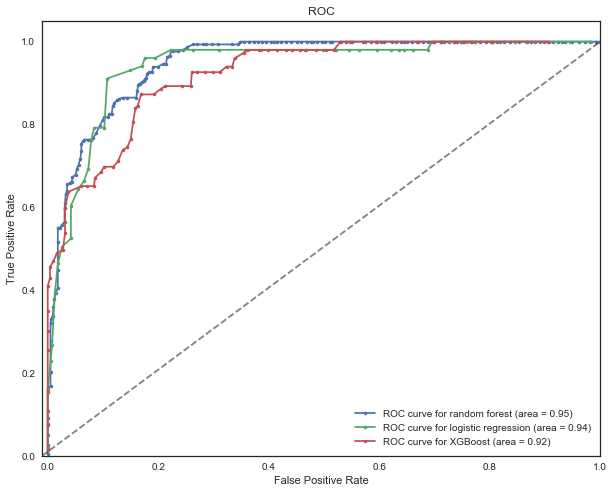

In [127]:
fig, ax = plt.subplots(1,figsize=(10,8))
ax, fpr, tpr, thresholds = make_roc("random forest", fpr1, tpr1, labe=10, skip=3)
ax, fpr, tpr, thresholds = make_roc("logistic regression", fpr_l, tpr_l, labe=10, skip=3)
ax, fpr, tpr, thresholds = make_roc("XGBoost", fpr_b, tpr_b, labe=10, skip=3)


### Multinomial Regression

In [2]:
# use the imputatation data as a baseline
data = pd.read_csv("ADNIMerge_PostImputation.csv")

In [3]:
adni1 = data[data['COLPROT'] =='ADNI1']

# drop some columns
columns = ['Unnamed: 0','VISCODE','EXAMDATE_bl', 'DX_bl','ORIGPROT','COLPROT','EXAMDATE','FAQ','FAQ_bl','Years_bl','Month_bl','M','PTETHCAT',
           'CDRSB','CDRSB_bl','MMSE','MMSE_bl','FLDSTRENG_bl','FSVERSION_bl','update_stamp','FLDSTRENG','FSVERSION','SITE','PTID',
          'RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting']
adni1 =adni1.drop(columns, axis=1)
adni1.head()

,RID,AGE,PTGENDER,PTEDUCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,...,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Month
0,2,0.537838,Male,16,White,Married,0.0,0.656019,0.070941,0.094271,...,0.555557,0.095237,0.333333,0.944443,0.666667,0.531305,0.665405,0.365854,0.237378,0.000000
1,3,0.727027,Male,18,White,Married,0.5,0.406609,0.648022,0.308011,...,0.259260,0.047620,0.200000,0.222223,0.500000,0.249885,0.389666,0.654102,0.415698,0.000000
2,3,0.727027,Male,18,White,Married,0.5,0.382257,0.552524,0.344773,...,0.222223,0.333333,0.200000,0.200000,0.250000,0.286955,0.389666,0.944568,0.372792,0.045455
3,3,0.727027,Male,18,White,Married,0.5,0.418298,0.477490,0.369602,...,0.333333,0.190477,0.083333,0.000000,0.250000,0.226088,0.389666,0.585366,0.451948,0.090909
4,3,0.727027,Male,18,White,Married,0.5,0.359964,0.451569,0.398939,...,0.000000,0.095237,0.000000,0.000000,0.000000,0.029067,0.389666,0.851441,0.540995,0.181818


In [4]:
# convert categorical columns
categorical_columns = ['PTGENDER','PTRACCAT', 'PTMARRY']

# get all the heads from the dataframe
head = adni1.columns.values.tolist()
numerical_columns = [a for a in head if a not in categorical_columns]
numerical_columns = [x for x in numerical_columns if x != 'DX']

In [5]:
adni1 = pd.get_dummies(adni1, columns=categorical_columns, drop_first=True)
adni1.head()

,RID,AGE,PTEDUCAT,APOE4,FDG,PIB,AV45,ADAS11,ADAS13,MOCA,...,Month,PTGENDER_Male,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_More than one,PTRACCAT_White,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed
0,2,0.537838,16,0.0,0.656019,0.070941,0.094271,0.152429,0.219647,0.766667,...,0.000000,1,0,0,0,1,1,0,0,0
1,3,0.727027,18,0.5,0.406609,0.648022,0.308011,0.314286,0.364706,0.600000,...,0.000000,1,0,0,0,1,1,0,0,0
2,3,0.727027,18,0.5,0.382257,0.552524,0.344773,0.271429,0.352941,0.633333,...,0.045455,1,0,0,0,1,1,0,0,0
3,3,0.727027,18,0.5,0.418298,0.477490,0.369602,0.342857,0.411765,0.500000,...,0.090909,1,0,0,0,1,1,0,0,0
4,3,0.727027,18,0.5,0.359964,0.451569,0.398939,0.366714,0.443176,0.500000,...,0.181818,1,0,0,0,1,1,0,0,0


In [13]:
# convert DX from categorical to numbers
adni1.DX = pd.Categorical(adni1.DX).codes
adni1["DX"].values

array([1, 2, 2, ..., 2, 0, 2], dtype=int8)

In [7]:
# randomly split dataset
gb = adni1.groupby('RID')    
groups=[gb.get_group(x) for x in gb.groups]


index_train = random.sample(range(0,len(groups)), int(len(groups)/2))
index_test = list(set(list(range(0,len(groups)))) - set(index_train))


train_df = pd.concat([groups[i] for i in index_train])
test_df = pd.concat([groups[i] for i in index_test])

In [8]:
#  standardize
mean = train_df[numerical_columns].mean()
std = train_df[numerical_columns].std()

mean_t = test_df[numerical_columns].mean()
std_t = test_df[numerical_columns].std()

train_df[numerical_columns] = (train_df[numerical_columns] - mean)/std
test_df[numerical_columns] = (test_df[numerical_columns] - mean_t)/std_t

In [9]:
X_train=train_df.drop(['DX','RID'], axis=1)
y_train=train_df['DX']

X_test=test_df.drop(['DX','RID'], axis=1)
y_test=test_df['DX']

In [10]:
#Multinomial
multinomial = LogisticRegressionCV(multi_class = 'multinomial', solver = 'newton-cg',cv=5, penalty='l2')
multinomial.fit(X_train, y_train)

#One v. Rest
ovr = LogisticRegressionCV(multi_class = 'ovr')
ovr.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [11]:
#Computing the score
print('OVR Logistic Regression Train Score: ',ovr.score(X_train, y_train))
print('Multinomial Logistic Regression Train Score: ',multinomial.score(X_train, y_train))

#Computing the score
print('OVR Logistic Regression Test Score: ',ovr.score(X_test, y_test))
print('Multinomial Logistic Regression Test Score: ',multinomial.score(X_test, y_test))

OVR Logistic Regression Train Score:  0.667186890363
Multinomial Logistic Regression Train Score:  0.671478735856
OVR Logistic Regression Test Score:  0.609387755102
Multinomial Logistic Regression Test Score:  0.611836734694
